# Analyze UrbanSound8k

## Resources
* librosa: https://librosa.org/doc/latest/index.html

## Import modules

In [1]:
import IPython as ip
import os 
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import pywt
import librosa
import librosa.display
import sounddevice as sd
import soundfile as sf
import matplotlib
import matplotlib.pyplot as plt

## Get data

In [2]:
def downloadUrbanSound8k():
    """ Downloads UrbanSound8k dataset """
    os.system('wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz')
    os.system('tar -xzf urban8k.tgz')

In [3]:
#downloadUrbanSound8k()

## Declare paths

In [4]:
data_path = 'UrbanSound8K'
audio_path = 'audio'
meta_path = 'metadata'

In [5]:
test_path = 'UrbanSound8K/audio/fold1/17913-4-0-1.wav'

## Inspect metadata

In [6]:
meta_data = pd.read_csv(data_path+'/'+meta_path+'/UrbanSound8K.csv')
meta_data['duration'] = meta_data['end']-meta_data['start']
print(meta_data.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  duration  
0          dog_bark  0.317551  
1  children_playing  4.000000  
2  children_playing  4.000000  
3  children_playing  4.000000  
4  children_playing  4.000000  


In [7]:
meta_data.groupby(['classID','class']).size().reset_index().rename(columns={0:'count'})

,classID,class,count
0,0,air_conditioner,1000
1,1,car_horn,429
2,2,children_playing,1000
3,3,dog_bark,1000
4,4,drilling,1000
5,5,engine_idling,1000
6,6,gun_shot,374
7,7,jackhammer,1000
8,8,siren,929
9,9,street_music,1000


In [8]:
print(meta_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   duration         8732 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 614.1+ KB
None


children_playing    1000
engine_idling       1000
street_music        1000
air_conditioner     1000
jackhammer          1000
dog_bark            1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


<AxesSubplot:title={'center':'class dist.'}>

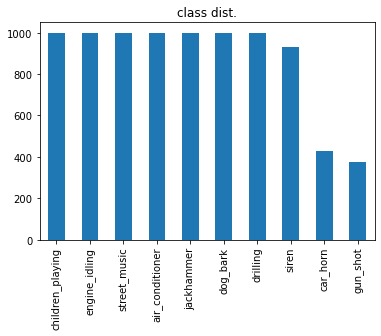

In [9]:
print(meta_data['class'].value_counts())
meta_data['class'].value_counts().plot(kind='bar',title='class dist.')

## Inspect audio files

In [10]:
audio_folders = glob(data_path+"/"+audio_path+"/f*")
audio_files = {}
for folder in sorted(audio_folders):
    audio_files[folder.split("/")[-1]] = glob(folder+"/*.wav")
n_samples = sum([len(audio_files[k]) for k in audio_files.keys()])
print("Number of samples: {}".format(n_samples))

Number of samples: 8732


In [11]:
def playAudioSample(sample_path):
    ''' Reads .wav file as np.array '''
    data, fs = sf.read(sample_path, dtype='float32') 
    sd.play(data, fs)
    status = sd.wait() 
    
def getSoundClass(sample_path,meta_data):
    row = meta_data[meta_data['slice_file_name'] == sample_path]
    return row['class'].values

In [12]:
print("Class: {}".format(getSoundClass(audio_files['fold1'][0].split("/")[-1],meta_data)))
playAudioSample(audio_files['fold1'][0])

Class: ['children_playing']


In [13]:
print("Class: {}".format(getSoundClass(audio_files['fold1'][1].split("/")[-1],meta_data)))
playAudioSample(audio_files['fold1'][1])

Class: ['gun_shot']


In [14]:
print("Class: {}".format(getSoundClass(audio_files['fold1'][2].split("/")[-1],meta_data)))
playAudioSample(audio_files['fold1'][2])

Class: ['air_conditioner']


## Make Log Mel-spectrograms

In [15]:
def LogMelSpectMesh(y,sr=22050):
    num_channels = 3
    window_sizes = [25, 50, 100]
    hop_sizes = [10, 25, 50]

    # Zero-padding for clip(size <= 2205)
    if len(y) <= 2205:
        clip = np.concatenate((y, np.zeros(2205 - len(y) + 1)))

    specs = []
    for i in range(num_channels):
        window_length = int(round(window_sizes[i]*sr/1000))
        hop_length = int(round(hop_sizes[i]*sr/1000))
        spec = librosa.feature.melspectrogram(y,sr=22050,n_fft=2205, win_length=window_length,\
                                             hop_length=hop_length,n_mels=128)
        spec = librosa.power_to_db(spec)
        spec = np.asarray(Image.fromarray(spec).resize((250,128)))
        
        # Scale between [0,1]
        spec = (spec - np.min(spec))/np.ptp(spec)
        
        specs.append(spec)
        
    specs = np.array(specs)
    specs = np.moveaxis(specs, 0, 2)
    return specs 

In [16]:
data, fs = librosa.load(test_path, sr=22050)
data_spect = LogMelSpectMesh(data)
print("LogMelSpectMesh shape: {}".format(data_spect.shape))

LogMelSpectMesh shape: (128, 250, 3)


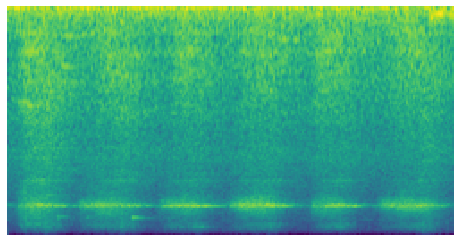

In [17]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,0], interpolation='nearest') 

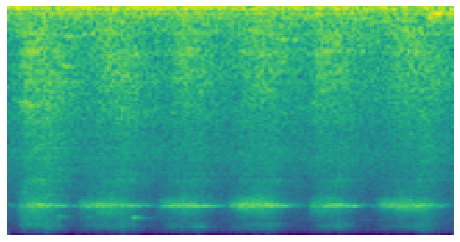

In [18]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,1], interpolation='nearest') 

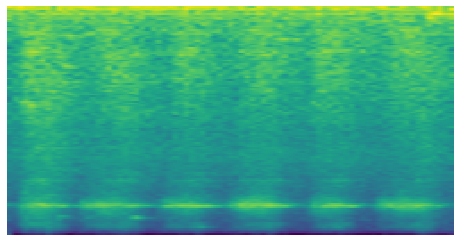

In [19]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,2], interpolation='nearest') 

## Make MFCC

In [20]:
def MFCCMesh(y,sr=22050):
    num_channels = 3
    window_sizes = [25, 50, 100]
    hop_sizes = [10, 25, 50]

    # Zero-padding for clip(size <= 2205)
    if len(y) <= 2205:
        clip = np.concatenate((y, np.zeros(2205 - len(y) + 1)))

    specs = []
    for i in range(num_channels):
        window_length = int(round(window_sizes[i]*sr/1000))
        hop_length = int(round(hop_sizes[i]*sr/1000))
        spec = librosa.feature.mfcc(y,sr=22050,n_fft=2205, win_length=window_length,\
                                             hop_length=hop_length,n_mfcc=128)
        spec = librosa.power_to_db(spec)
        spec = np.asarray(Image.fromarray(spec).resize((250,128)))
        
        # Scale between [0,1]
        spec = (spec - np.min(spec))/np.ptp(spec)
        
        specs.append(spec)
        
    specs = np.array(specs)
    specs = np.moveaxis(specs, 0, 2)
    return specs 

In [21]:
data, fs = librosa.load(test_path, sr=22050)
data_spect = MFCCMesh(data)
print("MFCCMesh shape: {}".format(data_spect.shape))

MFCCMesh shape: (128, 250, 3)


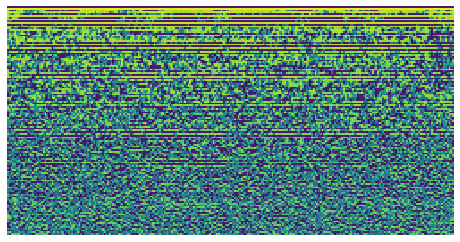

In [22]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,0], interpolation='nearest') 

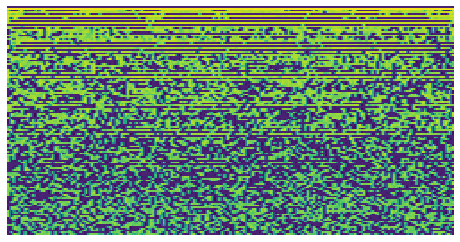

In [23]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,1], interpolation='nearest') 

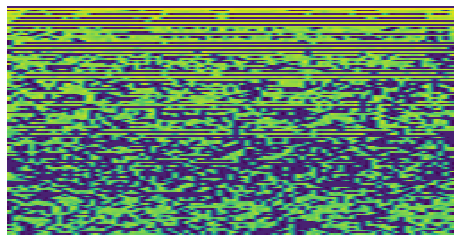

In [24]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,2], interpolation='nearest') 

## Make Chroma 

In [25]:
def ChromaMesh(y,sr=22050):
    num_channels = 3
    window_sizes = [25, 50, 100]
    hop_sizes = [10, 25, 50]

    # Zero-padding for clip(size <= 2205)
    if len(y) <= 2205:
        clip = np.concatenate((y, np.zeros(2205 - len(y) + 1)))

    specs = []
    for i in range(num_channels):
        window_length = int(round(window_sizes[i]*sr/1000))
        hop_length = int(round(hop_sizes[i]*sr/1000))
        spec = librosa.feature.chroma_stft(y,sr=22050,n_fft=2205, win_length=window_length,\
                                             hop_length=hop_length,n_chroma=128)
        spec = librosa.power_to_db(spec)
        spec = np.asarray(Image.fromarray(spec).resize((250,128)))
        
        # Scale between [0,1]
        spec = (spec - np.min(spec))/np.ptp(spec)
        
        specs.append(spec)
        
    specs = np.array(specs)
    specs = np.moveaxis(specs, 0, 2)
    return specs 

In [26]:
data, fs = librosa.load(test_path, sr=22050)
data_spect = ChromaMesh(data)
print("Chroma shape: {}".format(data_spect.shape))

Chroma shape: (128, 250, 3)


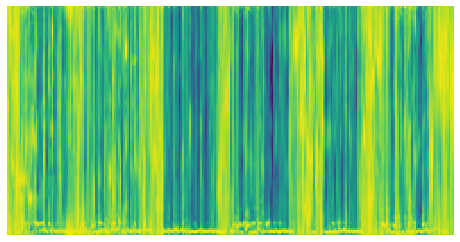

In [27]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,0], interpolation='nearest') 

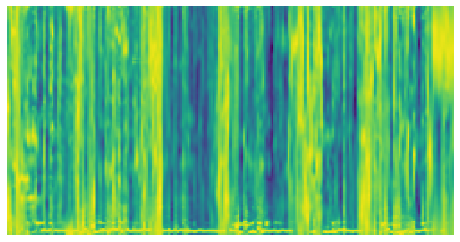

In [28]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,1], interpolation='nearest') 

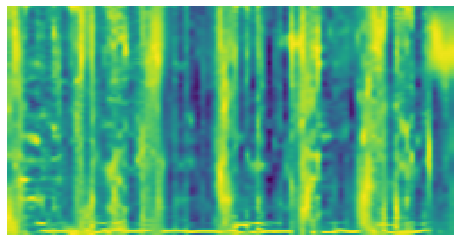

In [29]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect[:,:,2], interpolation='nearest') 

## Make CWT

In [30]:
def CWT(y, wavelet = 'morl'):
    scales = np.arange(1, 128) # range of scales
    coeffs, freqs = pywt.cwt(y, scales, wavelet = wavelet,method='fft')
    coeffs = np.asarray(Image.fromarray(coeffs).resize((250,128)))
    coeffs = librosa.power_to_db(coeffs)
    return coeffs

In [31]:
data, fs = librosa.load(test_path, sr=22050)

In [32]:
# 'mexh', 'morl', 'cmorB-C', 'gausP', 'cgauP', 'shanB-C', 'fpspM-B-C'
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

wavelet = 'gaus8' 
coeffs = CWT(data, wavelet = wavelet)

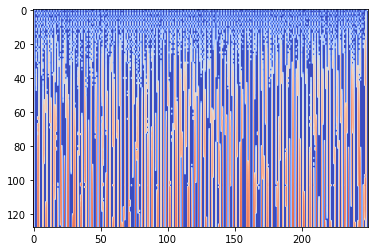

In [33]:
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')